In [1]:
import librosa
import numpy as np
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

### Loading Dataset

In [22]:
# Load audio
audio_path = 'audio1.wav'
y, sr = librosa.load(audio_path)

### Audio Visualization

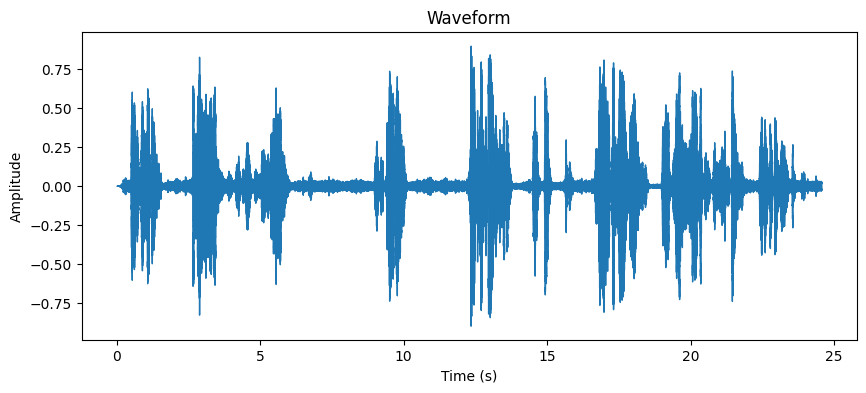

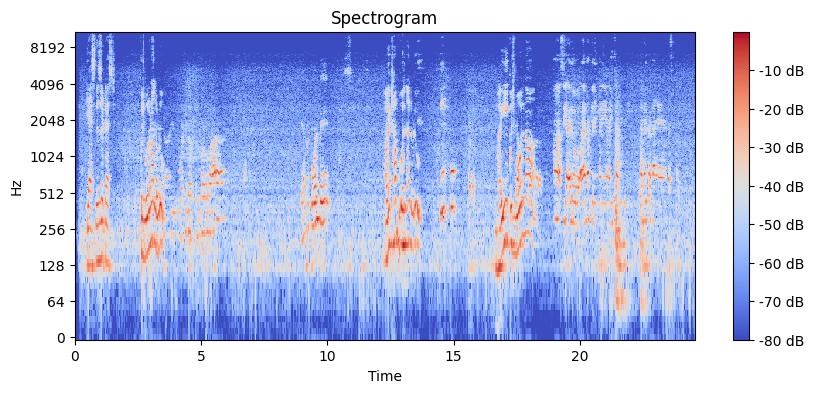

In [24]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.savefig('Waveform.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed

plt.show()

# Plot spectrogram
plt.figure(figsize=(10, 4))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.savefig('Spectogram.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed

plt.show()

### Feature Extraction

In [25]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)


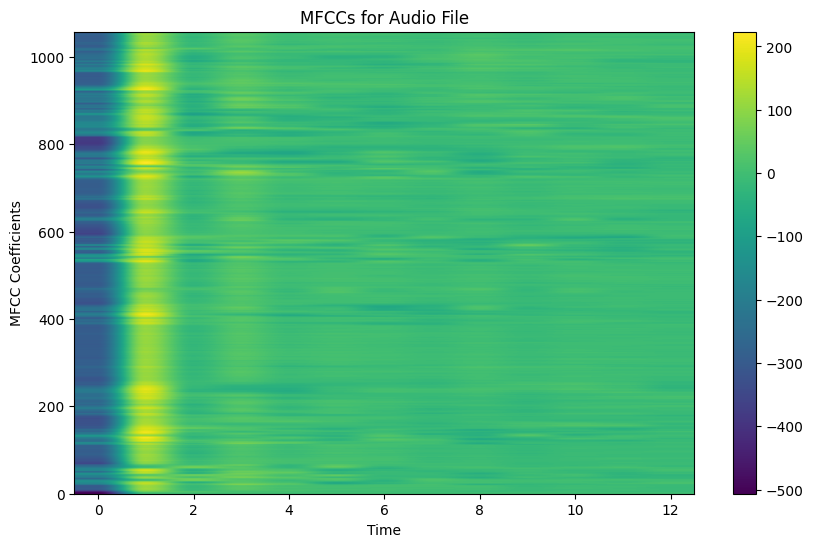

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(mfccs.T, aspect='auto', origin='lower')
plt.title('MFCCs for Audio File')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.savefig('MFCC_Plot.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed

plt.show()

In [27]:
scaler = StandardScaler()
mfccs_scaled = scaler.fit_transform(mfccs.T)  # Transpose for scaling

distance_matrix = squareform(pdist(mfccs_scaled, metric='euclidean'))

### Hierarchical Clustering

C:\Users\anujk\AppData\Local\Temp\ipykernel_16496\3638217504.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


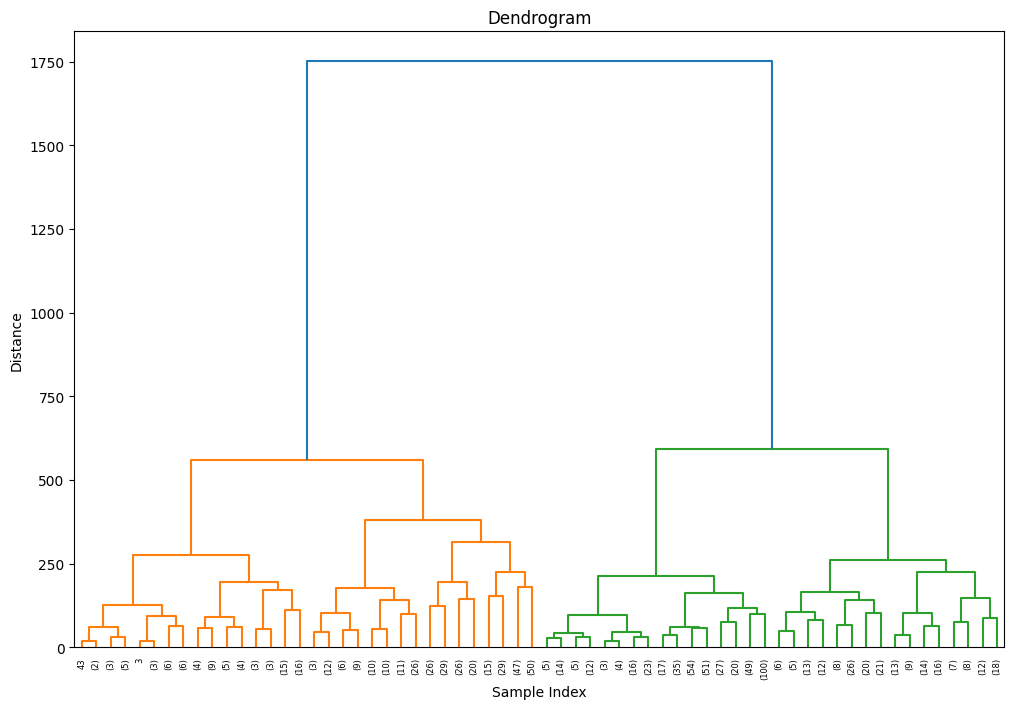

In [28]:
Z = linkage(distance_matrix, method='ward') 

plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('Dendrogram.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed
plt.show()


In [41]:
max_d = 570  #visually check
clusters = fcluster(Z, max_d, criterion='distance')

unique_labels, counts = np.unique(clusters, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} samples")

Cluster 1: 415 samples
Cluster 2: 435 samples
Cluster 3: 208 samples


### PCA Analysis

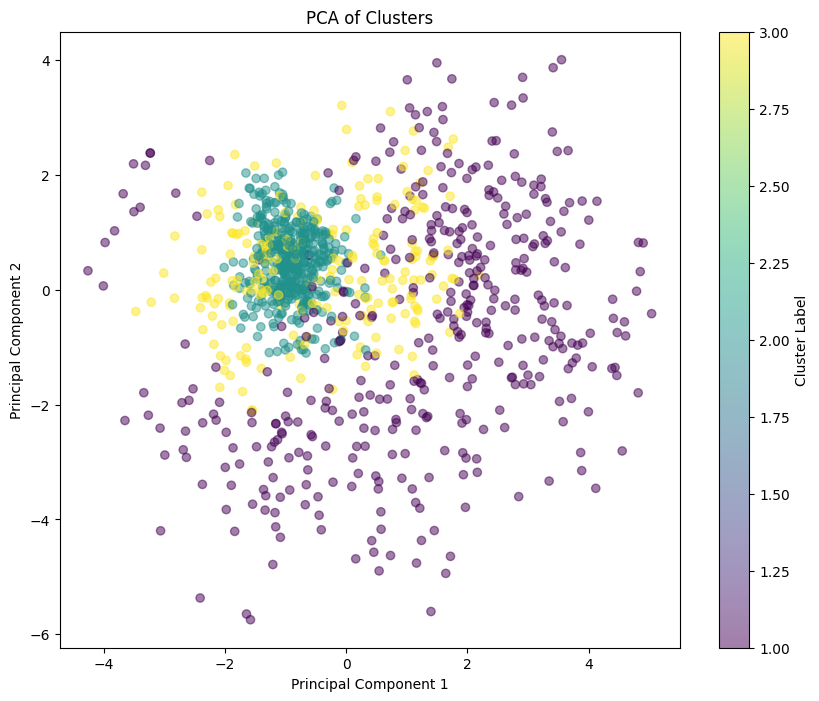

In [42]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mfccs_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

### Centroid Visualization

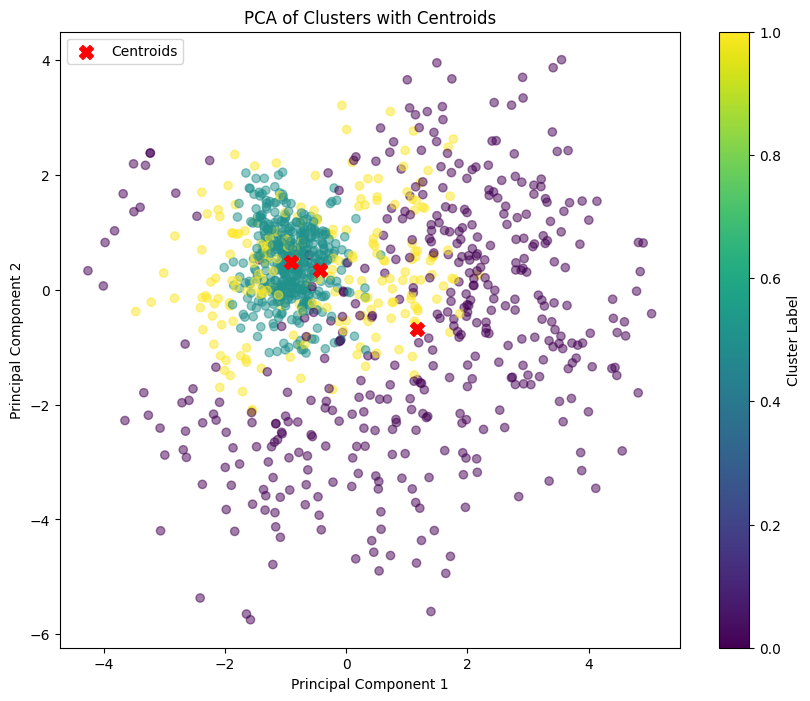

In [43]:
centroids = np.array([mfccs_scaled[clusters == i].mean(axis=0) for i in np.unique(clusters)])

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], marker='X', color='red', s=100, label='Centroids')
plt.title('PCA of Clusters with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.legend()
plt.savefig('PCA_Plot.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed

plt.show()

In [44]:
if len(clusters) == mfccs_scaled.shape[0]:
    features_df = pd.DataFrame(mfccs_scaled)
    features_df['Cluster'] = clusters
else:
    raise ValueError("Length of clusters does not match number of samples in mfccs_scaled.")

In [45]:
features_df_sorted = features_df.sort_values(by='Cluster')

heatmap_data = features_df_sorted.drop(columns='Cluster')

palette = sns.color_palette("coolwarm", n_colors=len(np.unique(clusters)))
row_colors = features_df_sorted['Cluster'].map({i: palette[i] for i in range(len(palette))})

scaler = MinMaxScaler()
heatmap_data = pd.DataFrame(scaler.fit_transform(heatmap_data), columns=heatmap_data.columns)


<Figure size 1400x1200 with 0 Axes>

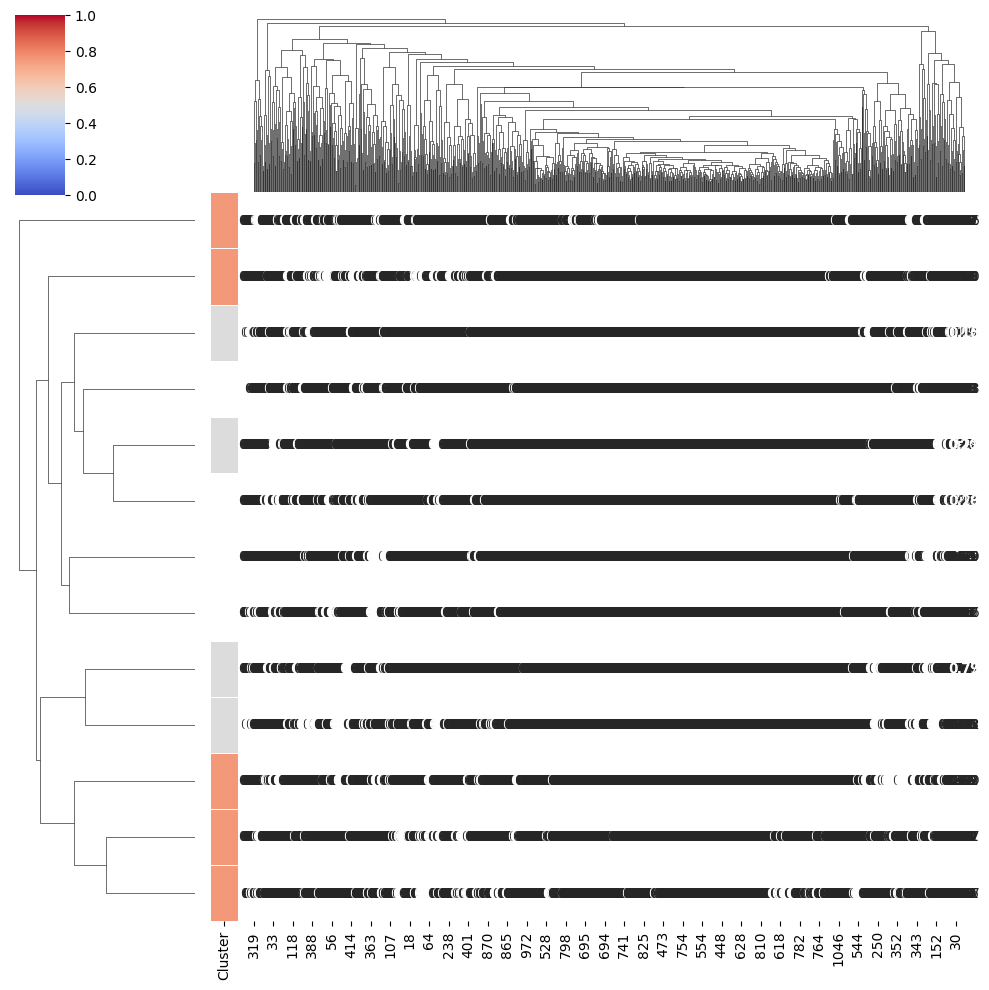

<Figure size 1400x1200 with 0 Axes>

In [46]:
sns.clustermap(
    heatmap_data.T,
    cmap='coolwarm',
    linewidths=0.5,
    row_colors=row_colors,
    yticklabels=False,
    annot=True, 
    fmt=".2f"    
)
plt.figure(figsize=(14, 12))  


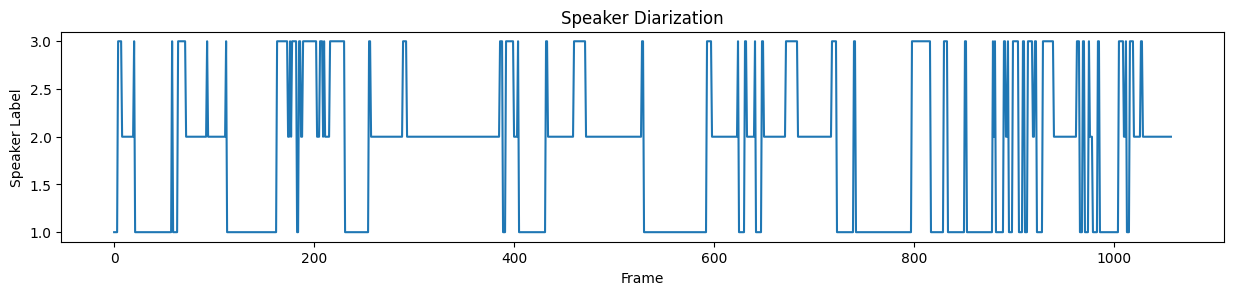

In [48]:
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 2)
plt.plot(clusters)
plt.title('Speaker Diarization')
plt.xlabel('Frame')
plt.ylabel('Speaker Label')
plt.savefig('hierarchical_clustering_last.png', dpi=300, bbox_inches='tight')  # Adjust dpi and format as needed

plt.show()